<a href="https://colab.research.google.com/github/itsasimiqbal/StARQ/blob/main/Inference_StARQ_2_0_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Colab to run StARQ inference on users' dataset` 🐁
```
Kaiser, J., Luong, D., Sung, E., Iqbal, A. and Sahni, V., 2023. Domain-Invariant Brainstem Nuclei Segmentation and Signal Quantification. bioRxiv, pp.2023-11.
```
[bioRxiv link](https://www.biorxiv.org/content/biorxiv/early/2023/11/11/2023.11.07.566040.full.pdf) | [GitHub link](https://github.com/itsasimiqbal/StARQ)

<!-- ![picture](https://github.com/itsasimiqbal/SeBRe/raw/master/SeBRe_block_diagram.png) -->
![picture](https://github.com/itsasimiqbal/StARQ/raw/main/GitHub_StARQ.png)


#### `import libraries`

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import os.path
from os import path
import os
import cv2
from skimage import measure
import gdown
import pandas as pd
import tarfile
import glob
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print('Available # of GPUs:', torch.cuda.device_count())
print('GPU type:', torch.cuda.get_device_name())
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install -U --no-cache-dir gdown --pre
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

import detectron2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.structures import BoxMode
from pycocotools.mask import encode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode

def square_padding(single_gray,square_size=256):
    # e.g. square_size = 256 by default
    # takes a raw image as input
    # returns a square (padded) image as output
    # input:  2D image
    # output: 2D resized padded image
    # example: BNI images, HMS data
    if len(np.shape(single_gray))>2:
      return square_padding_RGB(single_gray[:,:,:3])
    else:
      if single_gray.shape[1]>single_gray.shape[0]: # width>height
        scale_percent = (square_size/single_gray.shape[1])*100
      else: # width<height
        scale_percent = (square_size/single_gray.shape[0])*100
      width = int(single_gray.shape[1] * scale_percent / 100); height = int(single_gray.shape[0] * scale_percent / 100); dim = (width, height)
      sect_mask = cv2.resize(single_gray, dim, interpolation = cv2.INTER_AREA)
      sect_padd = (np.ones((square_size,square_size)))*single_gray[-20,-20]#find a better solution for single_gray[100,-100]
      sect_padd[int((square_size-np.shape(sect_mask)[0])/2):int((square_size-np.shape(sect_mask)[0])/2)+np.shape(sect_mask)[0],
                  int((square_size-np.shape(sect_mask)[1])/2):int((square_size-np.shape(sect_mask)[1])/2)+np.shape(sect_mask)[1]] = sect_mask
      return sect_padd

def square_padding_RGB(single_RGB,square_size=256):
    # e.g. square_size = 256 by default
    # takes a raw image as input
    # returns a square (padded) image as output
    # input:  2D image
    # output: 2D resized padded image
    # example: BNI images, HMS data
    if single_RGB.shape[1]>single_RGB.shape[0]: # width>height
      scale_percent = (square_size/single_RGB.shape[1])*100
    else: # width<height
      scale_percent = (square_size/single_RGB.shape[0])*100
    width = int(single_RGB.shape[1] * scale_percent / 100); height = int(single_RGB.shape[0] * scale_percent / 100); dim = (width, height)
    sect_mask = cv2.resize(single_RGB, dim, interpolation = cv2.INTER_AREA)
    sect_padd = (np.ones((square_size,square_size,3)))*np.mean(single_RGB[:10,:10])
    sect_padd[int((square_size-np.shape(sect_mask)[0])/2):int((square_size-np.shape(sect_mask)[0])/2)+np.shape(sect_mask)[0],
                int((square_size-np.shape(sect_mask)[1])/2):int((square_size-np.shape(sect_mask)[1])/2)+np.shape(sect_mask)[1],:] = sect_mask
    return sect_padd

def extract_polygons(im):
  '''
  input: A 2D mask (grayscale) image
  output: polygons of the connected components extracted from the mask.
  '''
  contours = measure.find_contours(im, 0.1, fully_connected='high')
  polygons = []
  for obj in contours:
      polygon = []
      for contour in obj:
          polygon.append(contour[0])
          polygon.append(contour[1])
      polygons.append(polygon)

  return contours, polygons


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.4 ; cuda:  cu121
Available # of GPUs: 1
GPU type: Tesla T4
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-0jbuyb0_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0jbuyb0_
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb

In [27]:
# @title ### `User Input Required! Please select your custom data folder path (.tif image files) sitting in Google Drive`
# @markdown `Select path e.g. '/content/drive/MyDrive/...'`

# @markdown ---
# @markdown ### `Enter the input image folder path:`
data_path = "/content/drive/MyDrive/Cornell/StARQ_test_dataset" # @param {type:"string"}
# @markdown ---

# data_path = '/content/drive/MyDrive/Cornell/StARQ_test_dataset'
os.chdir(data_path)
tif_files = glob.glob('*.tif*')
print('total # of files:', len(tif_files))
print(tif_files)

# @markdown ---
# @markdown ### `Enter the path to save model:`
model_path = "/content/drive/MyDrive/Cornell/StARQ_model" # @param {type:"string"}
# @markdown ---

if path.exists(model_path) == False:
  os.mkdir(model_path)
  print('model_path folder created')
  # downloading weights

os.chdir(model_path)
url = "https://drive.google.com/file/d/1HRIk_21dh1HZtbuOQJ1CZprS8RU1jgYU/view?usp=sharing"
output = "StARQ_brainstem_MPM.tar"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)
my_tar = tarfile.open(model_path+'/'+'StARQ_brainstem_MPM.tar')
my_tar.extractall()
my_tar.close()
!ls

# @markdown ---
# @markdown ### `Enter the path to save results:`
save_path = "/content/drive/MyDrive/Cornell/StARQ_results" # @param {type:"string"}
# @markdown ---

if path.exists(save_path) == False:
  os.mkdir(save_path)
  print('save_path folder created')
  # downloading weights

total # of files: 2
['M1S1_M1_Bst_CM-GFP_RL-tdt_NisslFarRed_DAPI_s2.tif', 'M1S1_M1_Bst_CM-GFP_RL-tdt_NisslFarRed_DAPI_s19.tif']


Downloading...
From (original): https://drive.google.com/uc?id=1HRIk_21dh1HZtbuOQJ1CZprS8RU1jgYU
From (redirected): https://drive.google.com/uc?id=1HRIk_21dh1HZtbuOQJ1CZprS8RU1jgYU&confirm=t&uuid=7ed356f7-8e30-464c-8721-b20d2a0e6e6d
To: /content/drive/MyDrive/1 Asim Iqbal/Cornell/StARQ_model/StARQ_brainstem_MPM.tar
100%|██████████| 655M/655M [00:03<00:00, 198MB/s]


StARQ_brainstem_MPM  StARQ_brainstem_MPM.tar


### `User Input Required! Please select from the slider and run cell`

```
*  tif_file_index (in case you have multiple files in the Google Drive folder), default is 1 (index of second image in custom folder)
*  registration (e.g. Nissl) channel index (0/1/2/3), default is set to 2
*  signal channel index (0/1/2/3) on which you need signal quantification, default is set to 1
```

In [37]:
tiff_file_index = 1 # @param {type:"slider", min:0, max:10, step:1}
reg_ch_index = 2 # @param {type:"slider", min:0, max:3, step:1}
sig_ch_index = 1 # @param {type:"slider", min:0, max:3, step:1}

### `Image Loader`

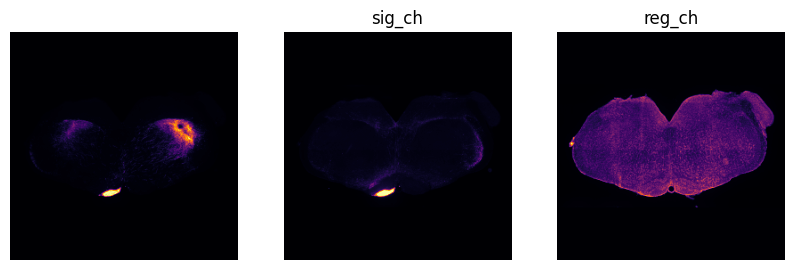

In [38]:
tif_image = tifffile.imread(data_path+'/'+tif_files[tiff_file_index])
tif_image_padded = np.zeros((256,256,len(tif_image)))
plt.figure(figsize=(10,5))
for x in range(len(tif_image)):
  plt.subplot(1,len(tif_image),x+1);
  tif_image_padded[:,:,x] = square_padding(tif_image[x])
  plt.imshow(tif_image_padded[:,:,x],cmap='inferno'); plt.axis('off')
  if x==reg_ch_index:
    plt.title('reg_ch')
  elif x==sig_ch_index:
    plt.title('sig_ch')

### `User Input (optional): `
```
Select a lower/higher inference_threshold if needed:

*   lower threshold e.g. 0 can result in multiple detections/False positives
*   higher threshold e.g. 0.99 can potentially miss the detections/False negatives, default is set to 0.7/1.0` 🤖


In [39]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))# cfg.DATASETS.TRAIN = ("mousenew_train",)# cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # change it for the max number of classes for custom dataset
for d in ["train", "val"]:
  MetadataCatalog.get("mousenew_" + d).set(thing_classes=['midbrain', 'pons','medulla'])#change these to your class labels
mouse_metadata = MetadataCatalog.get("mousenew_train")
print(MetadataCatalog['mousenew_train'])
cfg.CHECKPOINT_PERIOD = 100 # save checkpoint after every 100th iteration

cfg.OUTPUT_DIR = model_path+'/'+'StARQ_brainstem_MPM/Checkpoint'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0004999.pth")  # path to the model we just trained
inference_threshold = 0.7 # @param {type:"slider", min:0, max:1, step:0.1}
# set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = inference_threshold

predictor = DefaultPredictor(cfg)

Metadata(name='mousenew_train', thing_classes=['midbrain', 'pons', 'medulla'])
[10/03 18:39:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Cornell/StARQ_model/StARQ_brainstem_MPM/Checkpoint/model_0004999.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

### `Model Inference`

Text(0.5, 1.0, 'sig_ch')

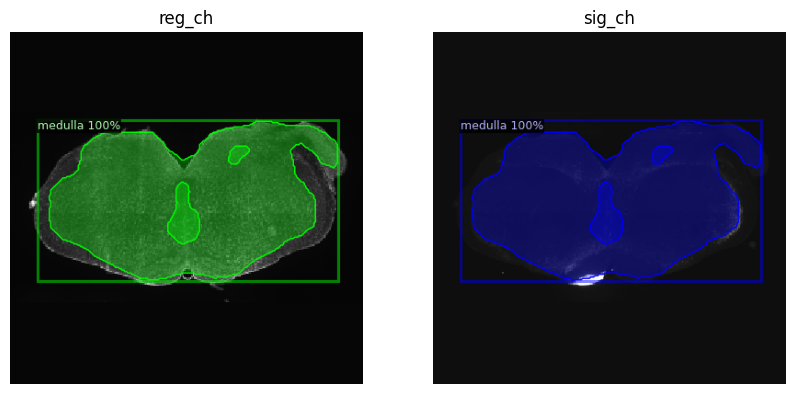

In [40]:
plt.figure(figsize=(10,5))
reg_image = np.zeros((256,256,3))
sig_image = np.zeros((256,256,3))
for x in range(3):
  reg_image[:,:,x] = tif_image_padded[:,:,reg_ch_index]
  sig_image[:,:,x] = tif_image_padded[:,:,sig_ch_index]
outputs = predictor(reg_image)

v = Visualizer(reg_image[:, :, ::-1],
                metadata=mouse_metadata,
                scale=1.5,
                instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.subplot(1,2,1)
plt.imshow(out.get_image()[:, :, ::-1]); plt.axis('off'); plt.title('reg_ch')

v = Visualizer(sig_image[:, :, ::-1],
                metadata=mouse_metadata,
                scale=1.5,
                instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.subplot(1,2,2)
plt.imshow(out.get_image()[:, :, ::-1]); plt.axis('off'); plt.title('sig_ch')

### `Visualizing results`

In [41]:
labels = {0:'Midbrain',
          1:'Pons',
          2:'Medulla'}

mouse_label_dict = {'Pons': [[220, 140, 60]],
                    'Midbrain': [[100, 0, 240]],
                    'Medulla': [[220, 20, 120]]}

M1S1_M1_Bst_CM-GFP_RL-tdt_NisslFarRed_DAPI_s19  ---  processed


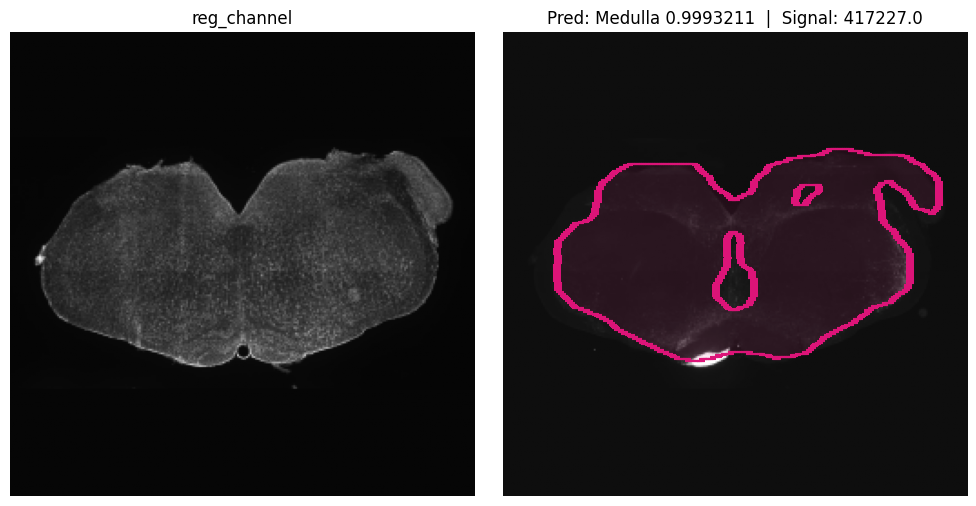

In [42]:
sect_masks = {}
sect_masks_area = {}
sect_confid = {}
sect_quants = {}

reg_image = np.zeros((256,256,3))
sig_image = np.zeros((256,256,3))
key = tif_files[tiff_file_index].split('.tif')[0]
count = 1
for x in range(3):
  reg_image[:,:,x] = tif_image_padded[:,:,reg_ch_index]
  sig_image[:,:,x] = tif_image_padded[:,:,sig_ch_index]
outputs = predictor(reg_image) # im = sect_C2_padd_RGB#cv2.imread(C1_load_path+C1_inference_sects[x])
mask = outputs['instances'].get('pred_masks'); mask = mask.to('cpu')
mask = np.uint8(mask.numpy()[0,:,:])*255
pred_classes = np.array(outputs['instances'].get('pred_classes').to('cpu'))
pred_scores = np.array(outputs['instances'].get('scores').to('cpu'))
sect_masks[key] =      {'Midbrain':[],'Pons':[],'Medulla':[]}
sect_masks_area[key] = {'Midbrain':[],'Pons':[],'Medulla':[]}
sect_confid[key] =     {'Midbrain':[],'Pons':[],'Medulla':[]}
sect_quants[key] =     {'Midbrain':[],'Pons':[],'Medulla':[]}


plt.figure(figsize=(10,5))
plt.subplot(1,len(pred_classes)+1,count); plt.imshow(reg_image/255,cmap='inferno'); plt.axis('off'); plt.title('reg_channel')
count+=1
pred_masks = outputs['instances'].get('pred_masks'); pred_masks = pred_masks.to('cpu').numpy()
temp_contours_global = []
temp_contours_global_color = []
global_temp_white = np.zeros((256,256,4))

for idx in range(len(pred_classes)):
  pred_temp = pred_masks[idx]
  temp_white = np.zeros((256,256,4))
  #temp = mouse_label_dict[labels[pred_classes[idx]]][0]
  for x in range(3):
    temp_white[:,:,x] = (pred_temp)*mouse_label_dict[labels[pred_classes[idx]]][0][x]/255
  temp_white[:,:,3] = pred_temp

  sect_masks[key][labels[pred_classes[idx]]] = np.uint(pred_temp)
  sect_masks_area[key][labels[pred_classes[idx]]] = np.sum(np.uint(pred_temp))
  sect_confid[key][labels[pred_classes[idx]]] = pred_scores[idx]
  sect_quants[key][labels[pred_classes[idx]]] = np.sum(sig_image[:,:,0]*np.uint8(pred_temp))
  plt.subplot(1,len(pred_classes)+1,count); plt.imshow(sig_image/255); plt.imshow(temp_white,cmap='inferno',alpha=0.1); plt.axis('off');
  plt.title('Pred: '+labels[pred_classes[idx]]+' '+str(pred_scores[idx])+'  |  Signal: '+str(np.sum(sig_image[:,:,0]*np.uint8(pred_temp))))
  temp_contours, temp_polygons = extract_polygons(pred_temp)
  if len(temp_contours)>0:
    for temp_cont in temp_contours:
      temp_contours_global.append(temp_cont)
      temp_contours_global_color.append([mouse_label_dict[labels[pred_classes[idx]]][0][0]/255,mouse_label_dict[labels[pred_classes[idx]]][0][1]/255,mouse_label_dict[labels[pred_classes[idx]]][0][2]/255])
      for val in temp_cont:
        plt.scatter(val[1],val[0],color=[mouse_label_dict[labels[pred_classes[idx]]][0][0]/255,mouse_label_dict[labels[pred_classes[idx]]][0][1]/255,mouse_label_dict[labels[pred_classes[idx]]][0][2]/255],marker=1)
  count+=1
print(key,' --- ', 'processed')
plt.tight_layout()

### `Saving results`

{'M1S1_M1_Bst_CM-GFP_RL-tdt_NisslFarRed_DAPI_s19': {'Midbrain': [], 'Pons': [], 'Medulla': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint64)}}
{'M1S1_M1_Bst_CM-GFP_RL-tdt_NisslFarRed_DAPI_s19': {'Midbrain': [], 'Pons': [], 'Medulla': 16463}}
{'M1S1_M1_Bst_CM-GFP_RL-tdt_NisslFarRed_DAPI_s19': {'Midbrain': [], 'Pons': [], 'Medulla': 417227.0}}
{'M1S1_M1_Bst_CM-GFP_RL-tdt_NisslFarRed_DAPI_s19': {'Midbrain': [], 'Pons': [], 'Medulla': 0.9993211}}


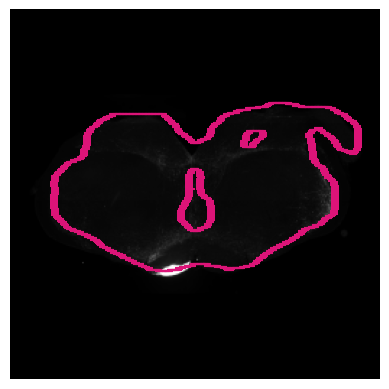

In [43]:
print(sect_masks)
print(sect_masks_area)
print(sect_quants)
print(sect_confid)
sect_confid_df = pd.DataFrame(sect_confid)
sect_quants_df = pd.DataFrame(sect_quants)
sect_masks_area_df = pd.DataFrame(sect_masks_area)
sect_confid_df.to_csv(save_path+'/'+key+"_confid.csv")
sect_quants_df.to_csv(save_path+'/'+key+"_quants.csv")
sect_masks_area_df.to_csv(save_path+'/'+key+"_mask_area.csv")
for mask in sect_masks[key]:
  if len(sect_masks[key][mask])>1:
    cv2.imwrite(save_path+'/'+key+'_'+mask+".png",sect_masks[key][mask]*255)

plt.figure()
plt.imshow(sig_image[:,:,0],cmap='gray')
plt.imshow(global_temp_white,cmap='inferno',alpha=0.1); plt.axis('off');
r_count = 0
for temp_cont in temp_contours_global:
    for val in temp_cont:
        plt.scatter(val[1],val[0],color=temp_contours_global_color[r_count],marker=1)
    r_count+=1
plt.savefig(save_path+'/'+key+"_"+'detections'+".svg",bbox_inches='tight', pad_inches=0)